## COMPETITION KAAGLE  


 Prédire les performances des élèves lors d'un apprentissage basé sur le jeu en temps réel  .

# 1. Définir un objectif mesurable : 

* Objectif : 

           Prédire les performances des élèves 
           lors d'un apprentissage basé sur le jeu en temps réel 
            en fonction des données disponibles sur KAAGLE .

* Metrique :
            F1 = 60% et Recall = 75%

            Rappel : F1 est le rapport entre la précision et le recall .

            le recall permet de réduire au maximum les faux négatifs .
 
            la précision permet de réduire au maximum les faux positifs .


# EXPLORATORY DATA ANALYSIS 


Objectif:

* Mieux comprendre nos données 
* Etablir une stratégie de modélisation 

#   Analyse de la forme : 

* Identification de la target : correct 
Classes légèrement équilibrés  (1  un peu plus de 63 %  , 0 un peu plus de 36 %)

* Nombre de lignes et de colonnes  : 89392050 ,	21


* Types de variables  : qualitatives : 7   , quantitatives : 13 

 








 

* Analyse des valeurs manquantes:
  - Des NaN (Deux variables  hover_duration et page > 90% de NaN)
  - Deux grands groupes de données  (0% de Nans   et  un groupe 0.09447)
  - Un groupe de  ( deux variables text et text_fqid avec 0.65262 de Nans)
  - Une variable fqid avec 0.31617





# Analyse du fond :

* Visualisation de la target (Histogramme / Boxplot)
* Comprehension des différentes variables (Internet -- Kaggle discusion )

* Visualisation de la target (Histogramme / Boxplot)
 qualques variables continues standardisées , skewed (asymétriques)  suivant une loi normale  
  ** Variable qualitative :elles ne sont pas  binaire , ce sont des variables qui possèdent plusieurs categories et la variable texte en possède le plus (énorme)
  ** Relation Variables / Target **
  - target/Medium_na : les variables text et text_fqid semblent liés a la performance des élèves 
  - target/Little_na : Les room_coordonnées et les screens_coordonnées x , y  semblent etres liés a la performance des élèves 
  - target/zero_na : les variables music , hq , level_group semblent  avoir un lien avec la performance des élèves (Hypothèse à tester)
* Visualisation des relations variables -target(Histogramme/Boxplot) 


* Identification des outliers 


Conclusion :

            - Une feature engineering avec les variables
              -- room_coord , screen_coord peuvent  apporter des informations supplémentaires pour nous permettre de répondre à la question
              -- Les variables text  et  text_fqid peuvent  également  nous apporter beaucoup d'informations puisqu'ils ont  plusieurs categories à étudier 
              -- Enfin les variables music , hq , level_group sont très liés à la performance 

In [32]:
#pip install polars 
#pip install pyarrow 


In [33]:
import polars as pl 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns   
import pyarrow

In [34]:
import polars as pl 

print(pl.__version__)

0.17.2


In [35]:
reader_features = pl.read_csv_batched(
    "./data/predict_student_game_performance_train.csv"
)  
features_data = reader_features.next_batches(100)  


features_data = pl.concat(features_data)


In [36]:
reader_labels = pl.read_csv_batched(
    "./data/predict_student_game_performance_train_labels.csv"
)  
target_data = reader_labels.next_batches(100) 
target_data = pl.concat(target_data)
# extraire les premiers 17 caractères de la colonne 'session_id'

target_data = target_data.with_columns(pl.col("session_id").str.split("_").apply(lambda x: x[0]))

target_data = target_data.with_columns(pl.col("session_id").cast(pl.Int64))







  




In [37]:
data = features_data.join(target_data , on = "session_id" , how="inner")





In [38]:
data=data.to_pandas()

df = data.copy()
df = df.head(600000)

In [39]:
df.shape # Nombre de lignes , Nombre de colonnes : dimensionalite du dataset

(600000, 21)

In [40]:
df.dtypes.value_counts()

int64      8
object     8
float64    5
Name: count, dtype: int64

<Axes: ylabel='count'>

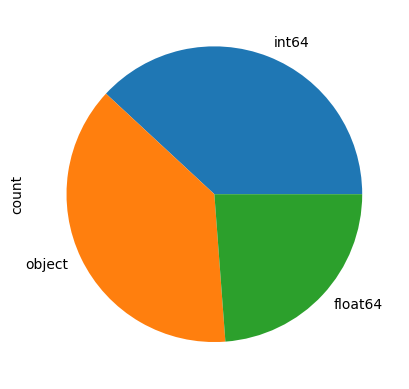

In [41]:
df.dtypes.value_counts().plot.pie()


 ### Analyse des NaN

<Axes: >

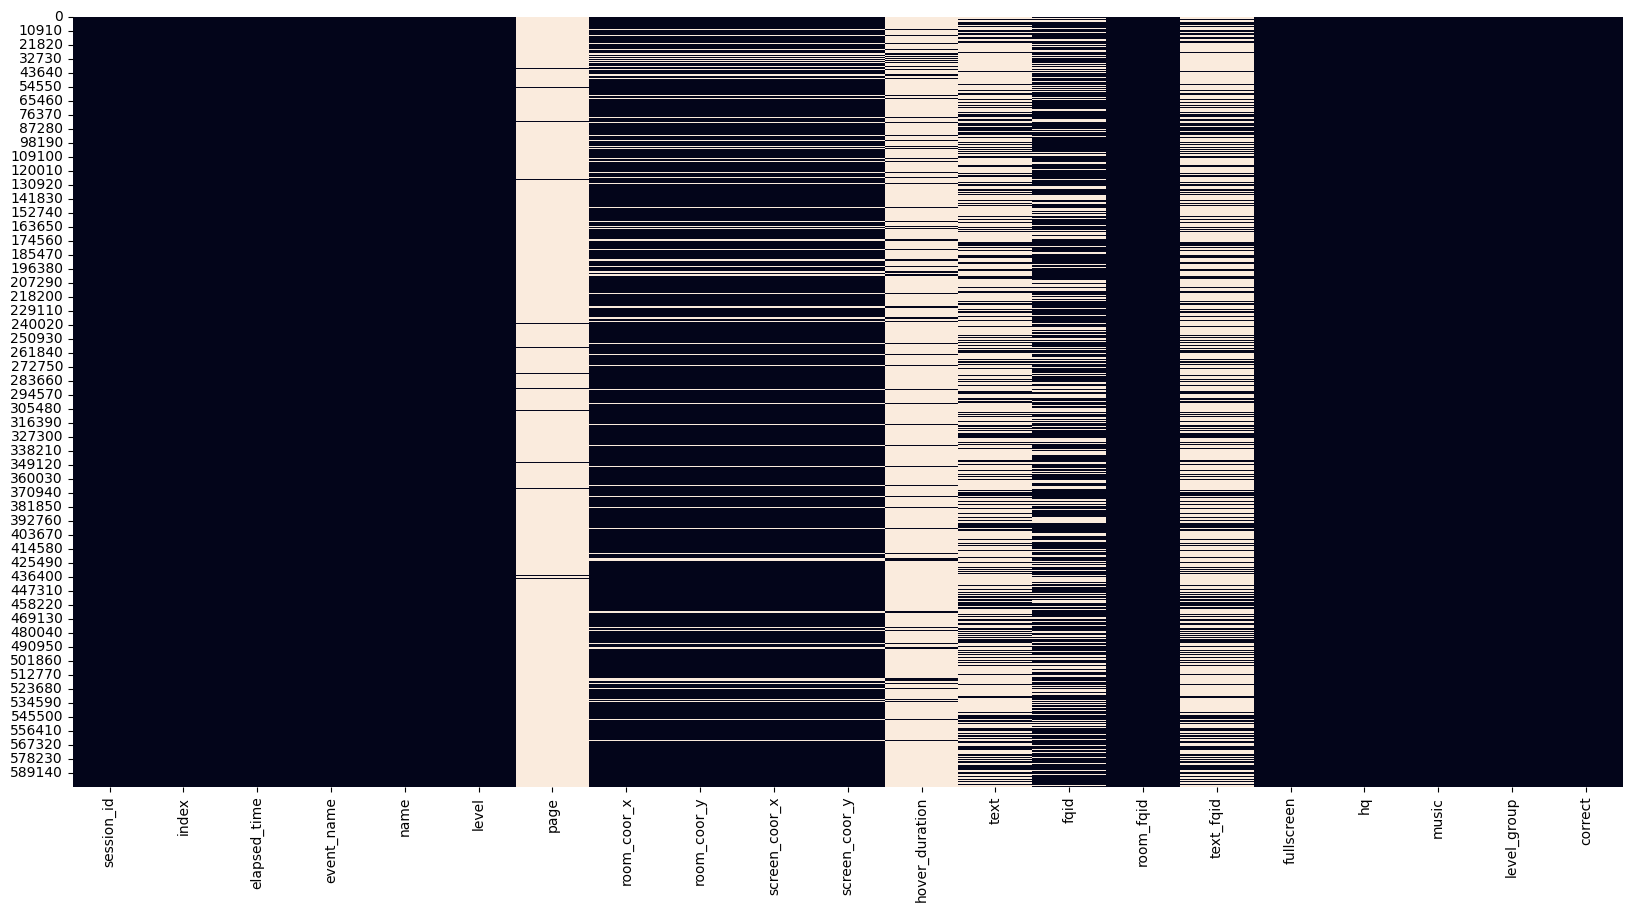

In [42]:
plt.figure(figsize = (20,10))
sns.heatmap(df.isna() , cbar=False)

## Mesurer le pourcentage de valeurs manquantes dans notre dataframe

In [43]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=False)


# 98 % des variable page est manquante c'est dingue 




page              0.97864
hover_duration    0.90811
text_fqid         0.65262
text              0.65262
fqid              0.31617
screen_coor_y     0.09447
room_coor_x       0.09447
room_coor_y       0.09447
screen_coor_x     0.09447
room_fqid         0.00000
level_group       0.00000
music             0.00000
hq                0.00000
fullscreen        0.00000
session_id        0.00000
index             0.00000
level             0.00000
name              0.00000
event_name        0.00000
elapsed_time      0.00000
correct           0.00000
dtype: float64

# Analyse du fond 

1. Visualisation intiale - Elimination des colonnes inules 

In [45]:

df = df[df.columns[df.isna().sum()/df.shape[0] < 0.9]]

df.head()

,session_id,index,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,correct
0,20090312431273200,0,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1
1,20090312431273200,0,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1
2,20090312431273200,0,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1
3,20090312431273200,0,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1
4,20090312431273200,0,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1


<Axes: >

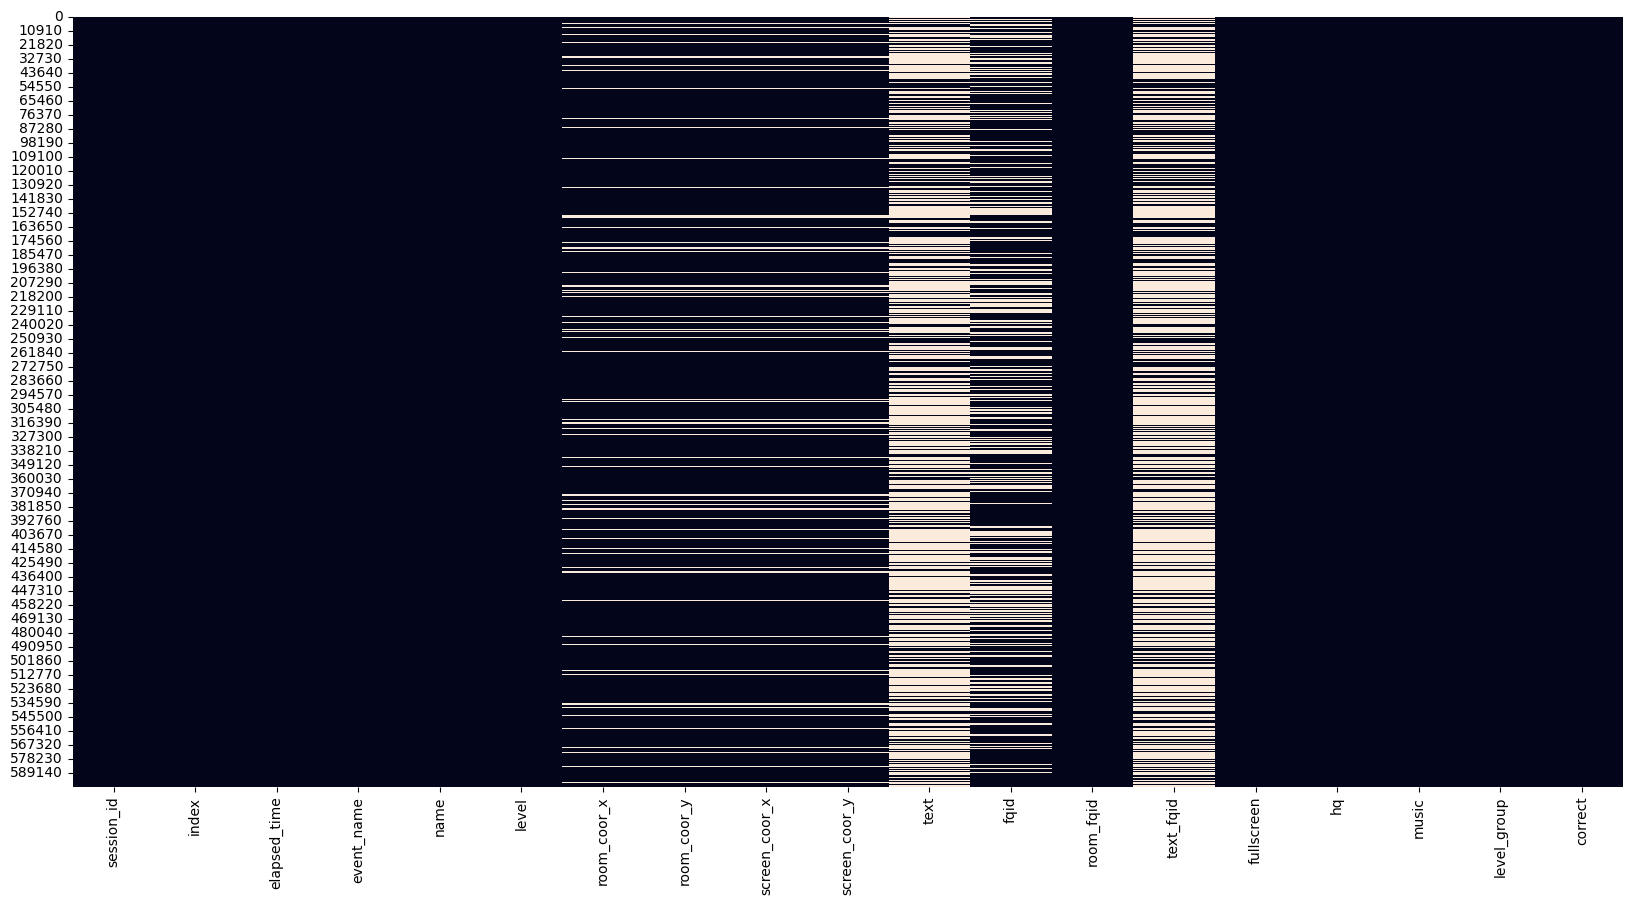

In [46]:
plt.figure(figsize = (20,10))
sns.heatmap(df.isna() , cbar=False)

In [48]:
df = df.drop('index' , axis=1)
#df = df.drop('session_id' , axis=1)
df.head()

,session_id,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,correct
0,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1
1,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1
2,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1
3,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1
4,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1


## Examen de la colonne target 

In [50]:
df['correct'].value_counts(normalize =True)

correct
1    0.635163
0    0.364837
Name: proportion, dtype: float64

## Histogrammes des variables continues 

<Figure size 640x480 with 0 Axes>

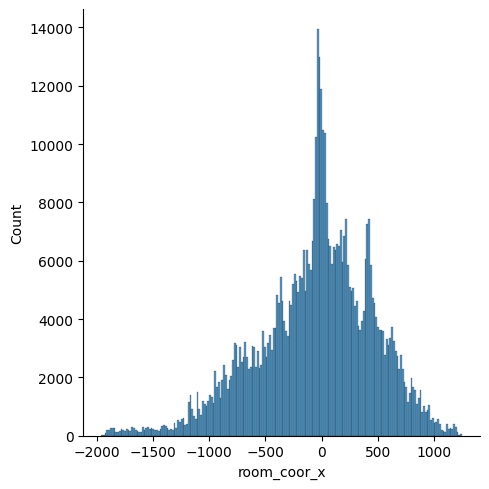

<Figure size 640x480 with 0 Axes>

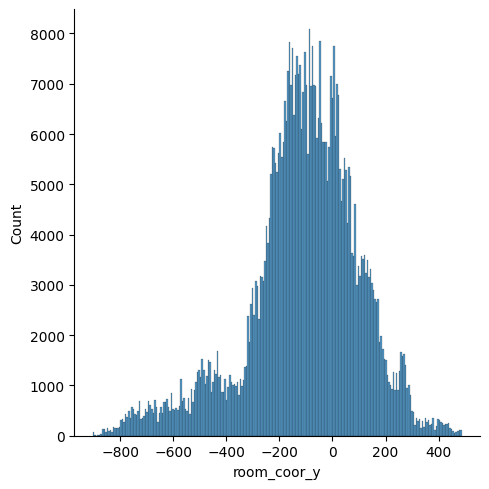

<Figure size 640x480 with 0 Axes>

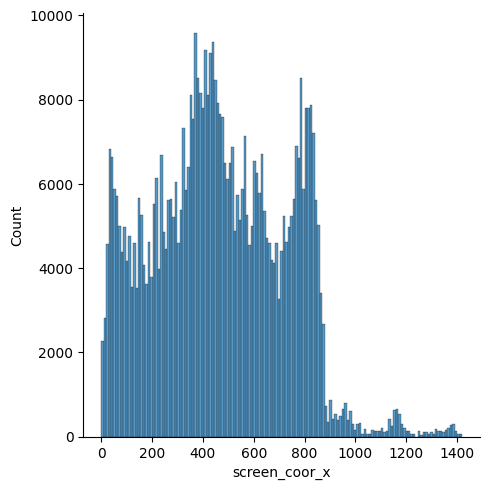

<Figure size 640x480 with 0 Axes>

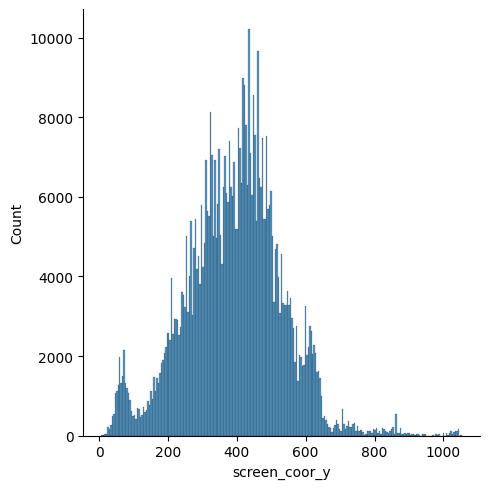

In [54]:
for col in df.select_dtypes('float'):
    plt.figure()
    sns.displot(df[col])
    #print(col)

In [55]:
df.head()

,session_id,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,correct
0,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1
1,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1
2,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1
3,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1
4,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,1


<Figure size 640x480 with 0 Axes>

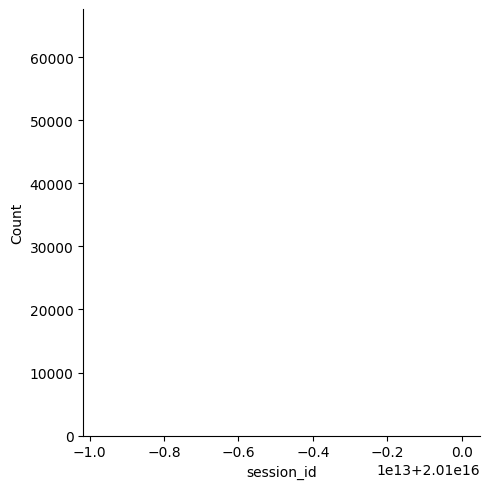

<Figure size 640x480 with 0 Axes>

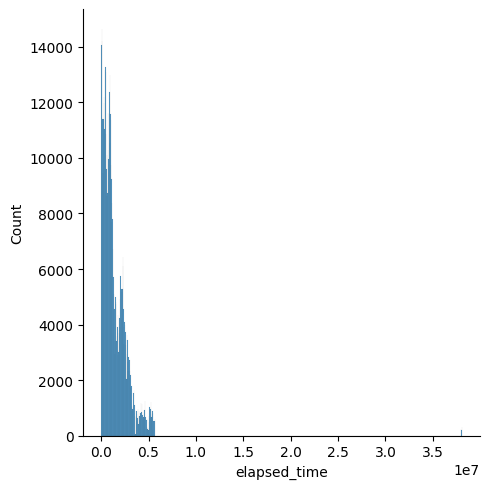

<Figure size 640x480 with 0 Axes>

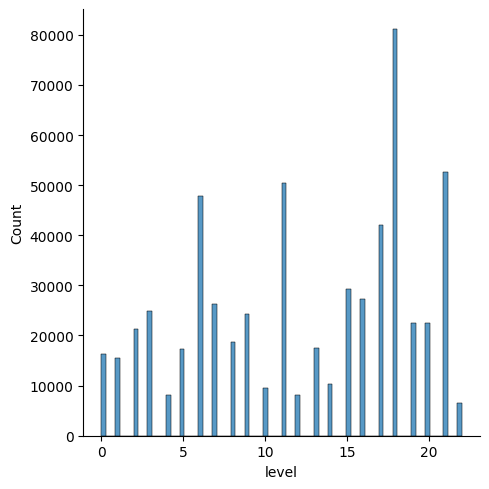

<Figure size 640x480 with 0 Axes>

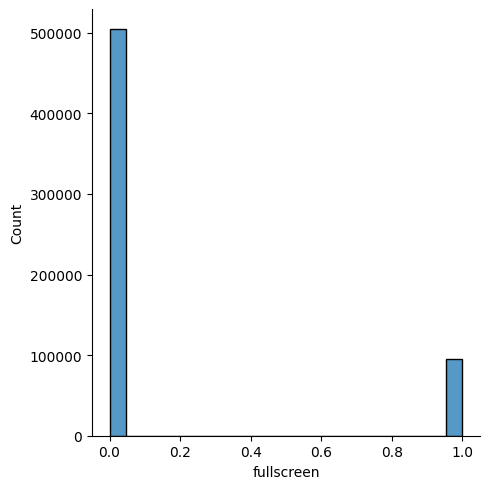

<Figure size 640x480 with 0 Axes>

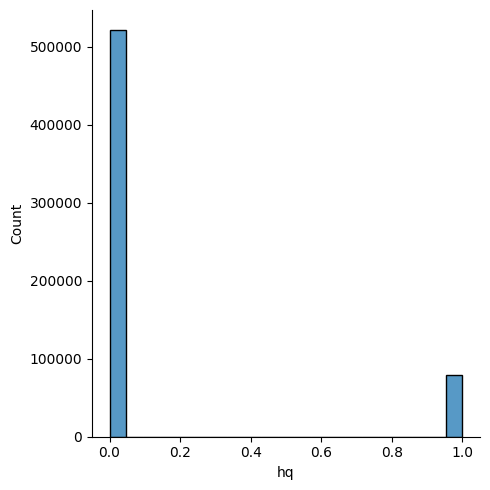

<Figure size 640x480 with 0 Axes>

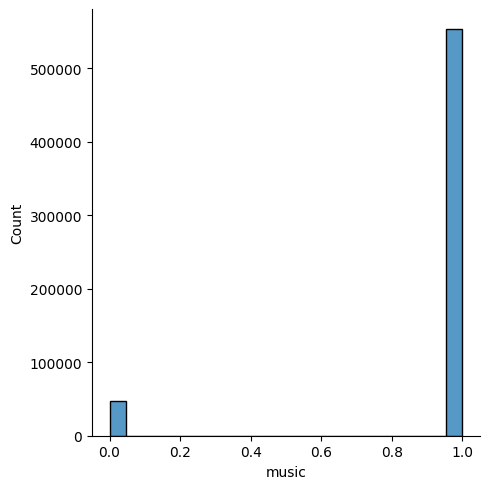

<Figure size 640x480 with 0 Axes>

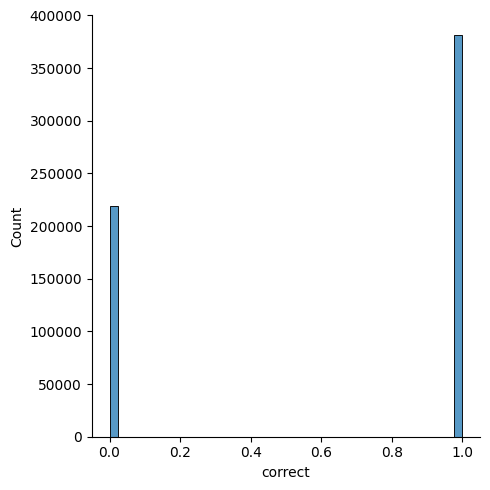

In [56]:
for col in df.select_dtypes('int'):
    plt.figure()
    sns.displot(df[col])

## Variables qualitatives 

##### 1. Différentes categories qu'il y'a dans chaque variable 


In [58]:
for col in df.select_dtypes('object'):

  print(f'{col :-<50} {df[col].unique()}')
# 1. Différentes categories qu'il y'a dans chaque variable 


event_name---------------------------------------- ['cutscene_click' 'person_click' 'navigate_click' 'observation_click'
 'notification_click' 'object_click' 'object_hover' 'map_hover'
 'map_click' 'checkpoint' 'notebook_click']
name---------------------------------------------- ['basic' 'undefined' 'close' 'open' 'prev' 'next']
text---------------------------------------------- ['undefined' 'Whatcha doing over there, Jo?' 'Just talking to Teddy.'
 'I gotta run to my meeting!' 'Can I come, Gramps?'
 'Sure thing, Jo. Grab your notebook and come upstairs!'
 'See you later, Teddy.' "I get to go to Gramps's meeting!"
 'Now where did I put my notebook?' '\\u00f0\\u0178\\u02dc\\u00b4' None
 'I love these photos of me and Teddy!' 'Found it!'
 'Gramps is in trouble for losing papers?' "This can't be right!"
 'Gramps is a great historian!' "Hmm. Button's still not working."
 "Let's get started. The Wisconsin Wonders exhibit opens tomorrow!"
 'Who wants to investigate the shirt artifact?'
 "Not 

##### 2. Counter le nombre de valeurs qu'il y'a dans chaque categorie

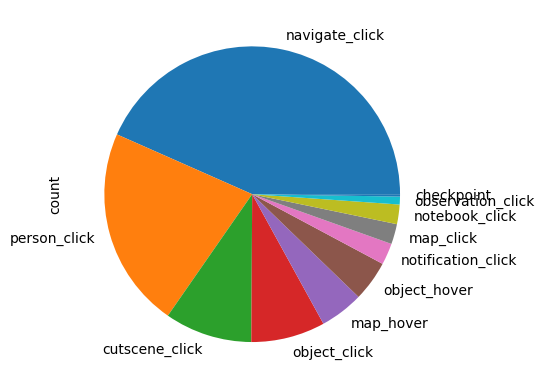

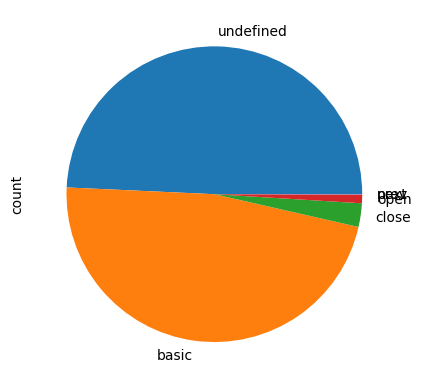

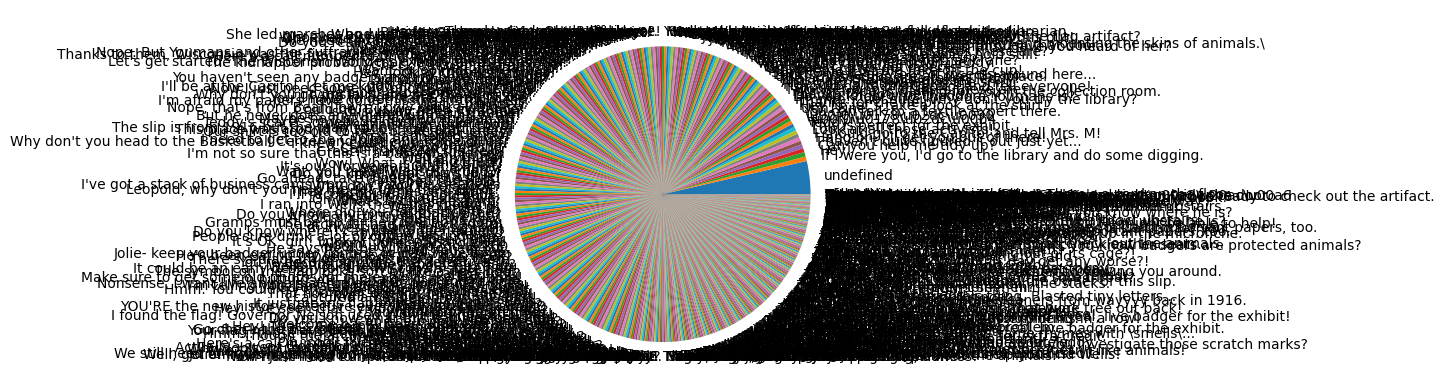

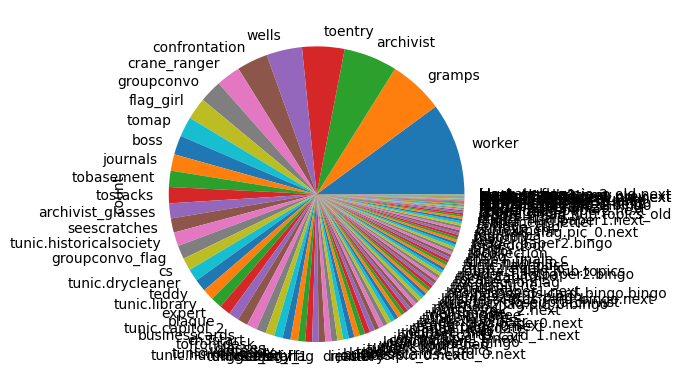

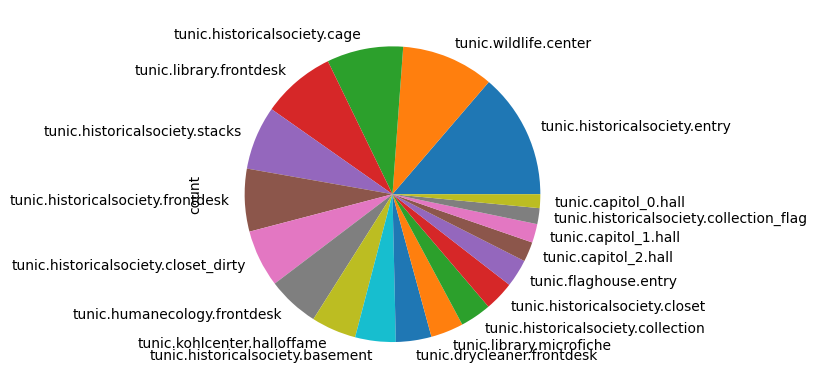

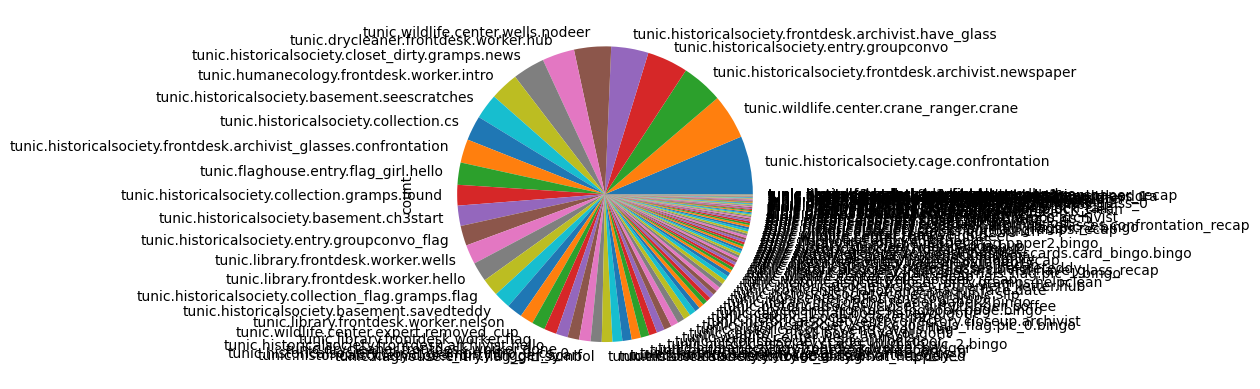

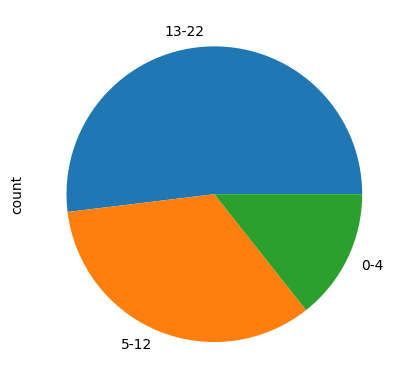

In [59]:
for col in df.select_dtypes('object'):
  plt.figure()
  df[col].value_counts().plot.pie()



  # 2. Counter le nombre de valeurs qu'il y'a dans chaque categorie

# Relation Target / Variables 

### Création des sous-ensembles reussites et échecs

In [74]:
reussite_df = df[df['correct'] == 1]


# Créer un dictionnaire de correspondance
mapping = {1: 'succès', 0: 'échec'}

# Utiliser la méthode map() pour convertir les valeurs
reussite_df['correct'] = reussite_df['correct'].astype('object').map(mapping)


reussite_df.head()


/var/folders/20/j5yjkwj15ts7__y_rbh9222h0000gn/T/ipykernel_37573/2546378370.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reussite_df['correct'] = reussite_df['correct'].astype('object').map(mapping)


,session_id,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,correct
0,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,succès
1,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,succès
2,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,succès
3,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,succès
4,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,succès


In [81]:
echec_df = df[df['correct']==0]

# Créer un dictionnaire de correspondance
mapping = {1 : 'succès', 0 : 'échec'}

# Utiliser la méthode map() pour convertir les valeurs
echec_df['correct'] = echec_df['correct'].astype('object').map(mapping)


echec_df.head()

/var/folders/20/j5yjkwj15ts7__y_rbh9222h0000gn/T/ipykernel_37573/2850796139.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  echec_df['correct'] = echec_df['correct'].astype('object').map(mapping)


,session_id,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,correct
12,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,échec
15,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,échec
30,20090312431273200,1323,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,échec
33,20090312431273200,1323,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,échec
48,20090312431273200,831,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,échec


### Création des sous-ensembles identifiés lors de l'analyse des Nans 

In [66]:
missing_rate = df.isna().sum()/df.shape[0]


In [68]:
medium_na = df.columns[(missing_rate < 0.9) & (missing_rate > 0.50)]

In [69]:
little_na = df.columns[(missing_rate < 0.5) & (missing_rate > 0.05)]

In [94]:
zero_na = df.columns[(missing_rate == 0)]


## Target / Zero_na

/usr/local/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


<Figure size 640x480 with 0 Axes>

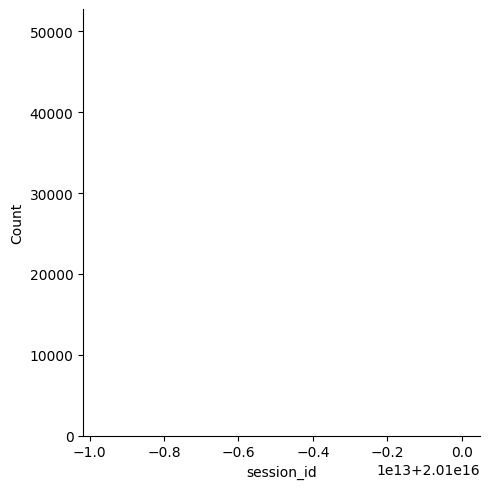

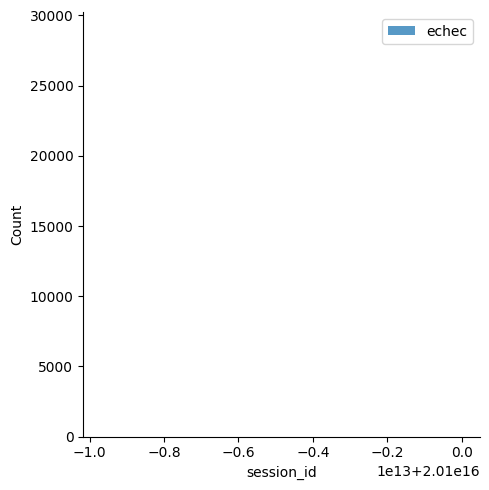

<Figure size 640x480 with 0 Axes>

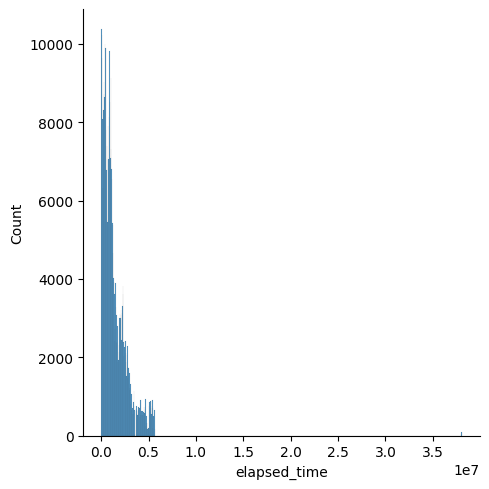

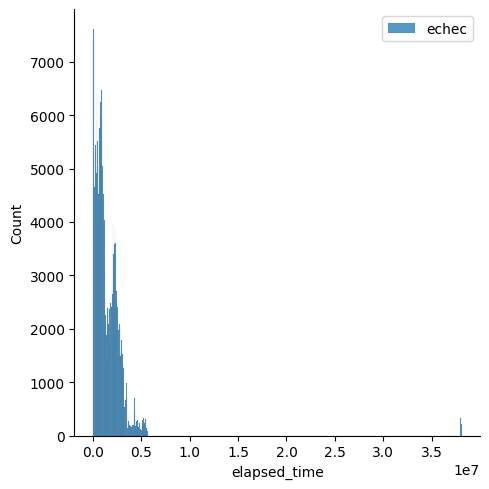

<Figure size 640x480 with 0 Axes>

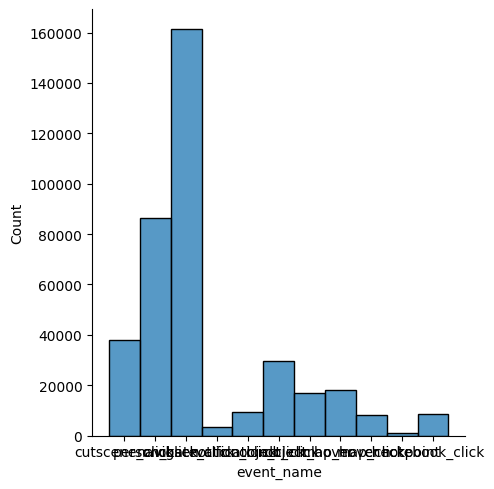

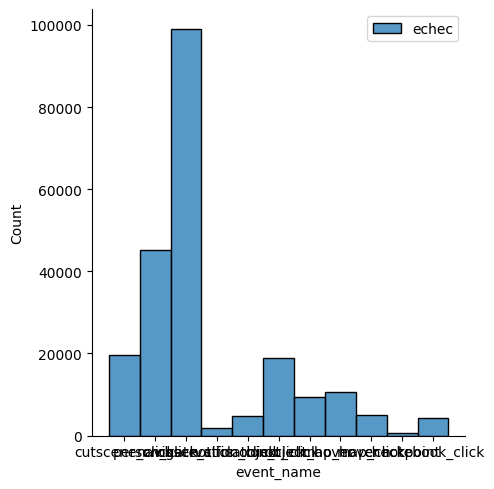

<Figure size 640x480 with 0 Axes>

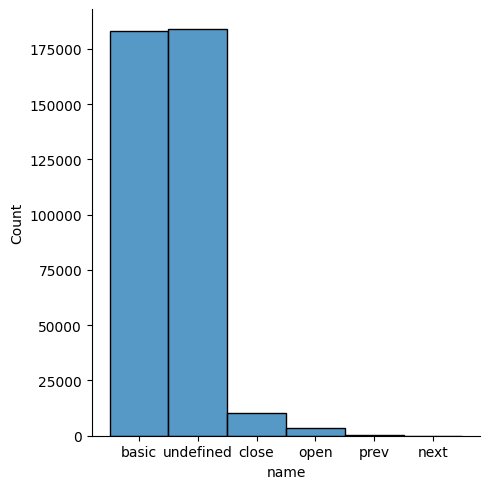

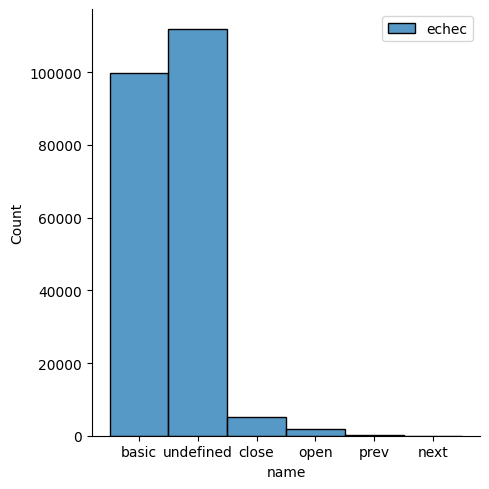

<Figure size 640x480 with 0 Axes>

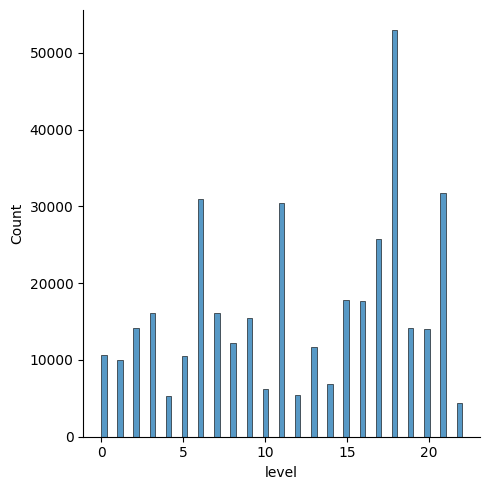

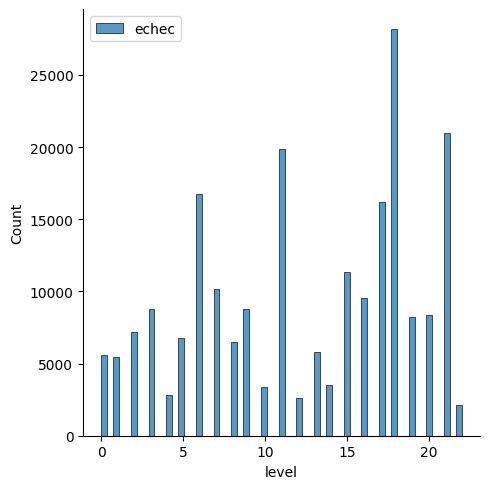

<Figure size 640x480 with 0 Axes>

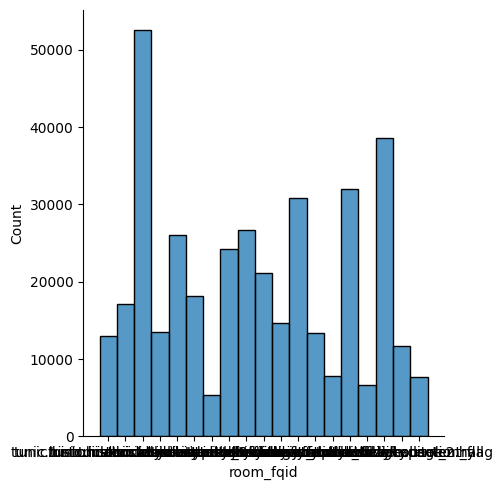

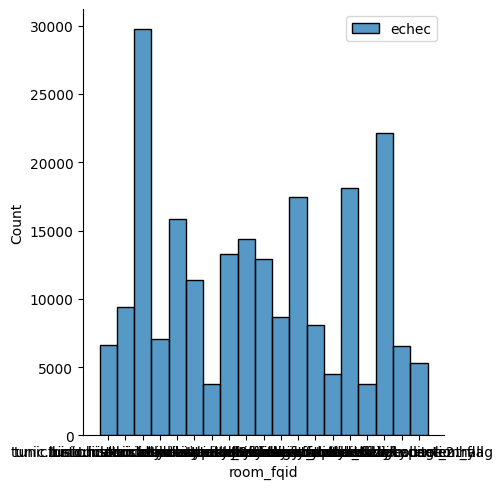

<Figure size 640x480 with 0 Axes>

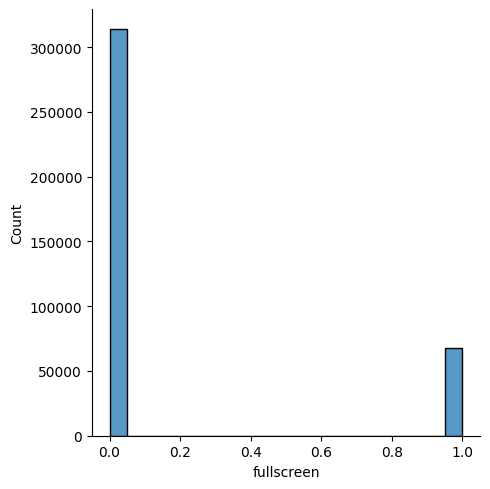

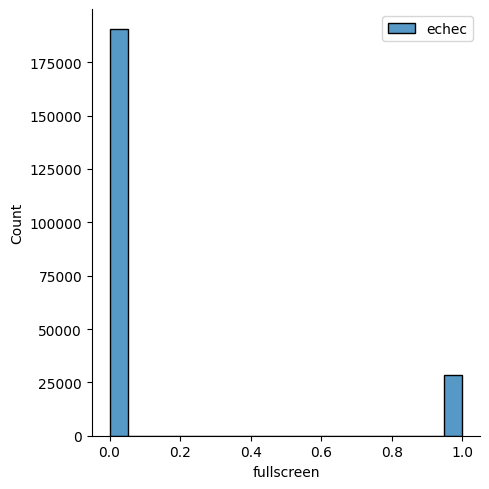

<Figure size 640x480 with 0 Axes>

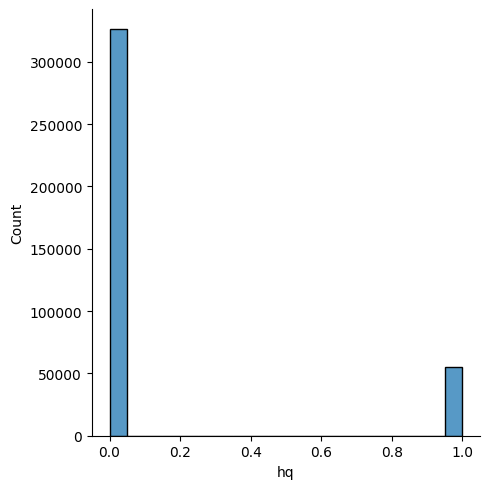

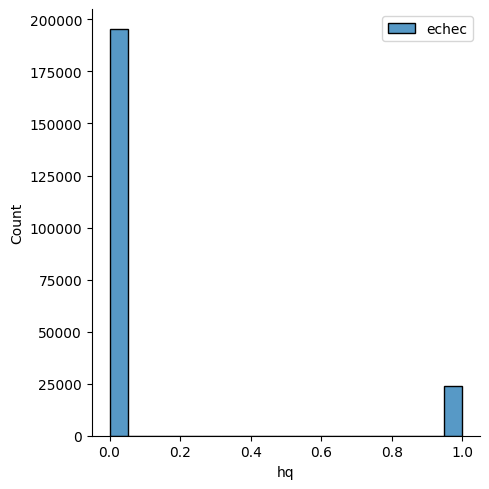

<Figure size 640x480 with 0 Axes>

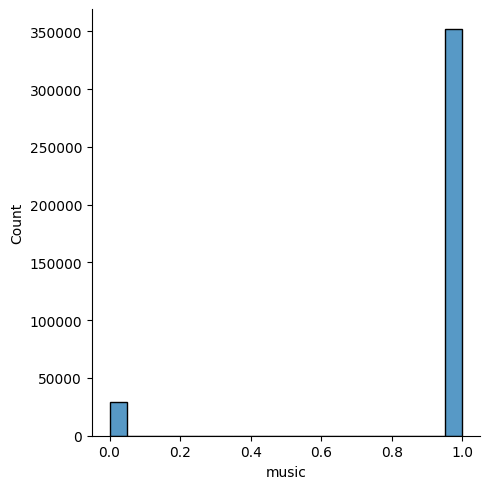

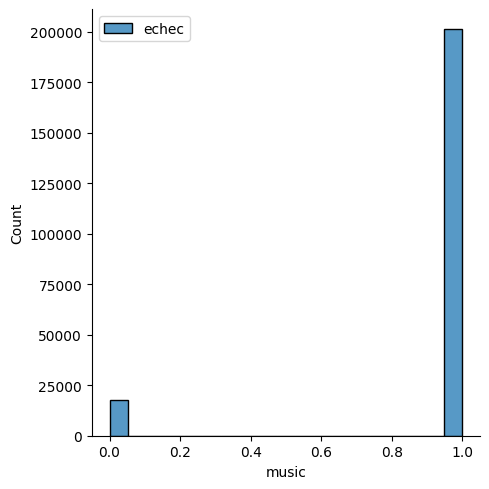

<Figure size 640x480 with 0 Axes>

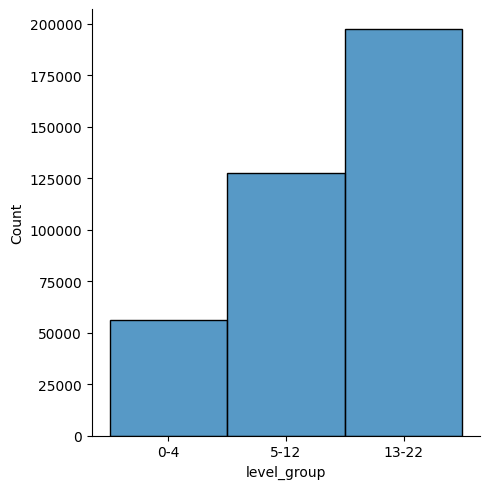

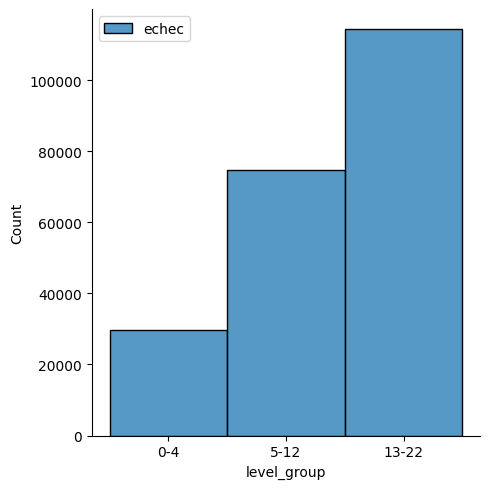

<Figure size 640x480 with 0 Axes>

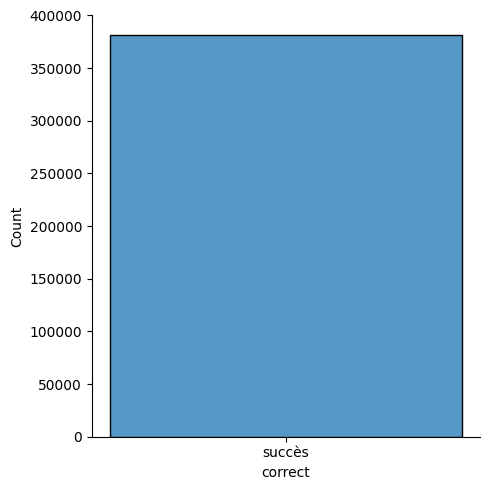

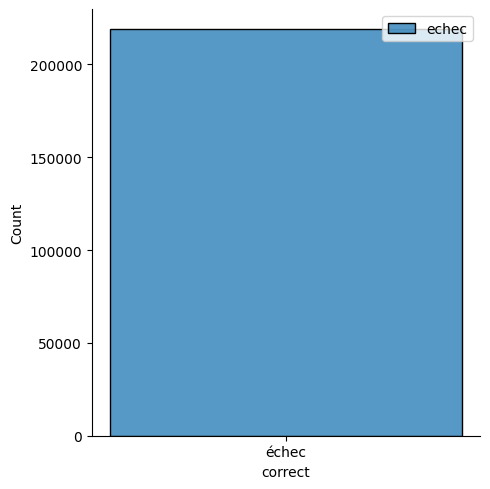

In [95]:
for col in zero_na:
    plt.figure()
    sns.displot(reussite_df[col] , label = 'succès')
    sns.displot(echec_df[col] , label = 'echec')
    plt.legend()



In [ ]:
## Target / Little_na

<Figure size 640x480 with 0 Axes>

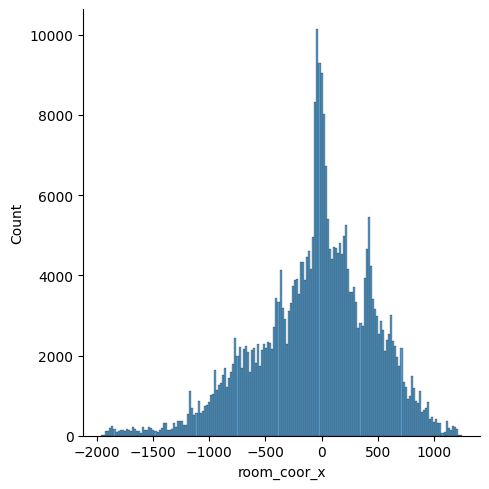

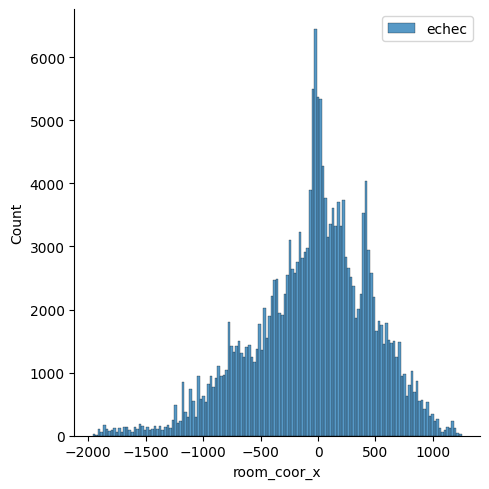

<Figure size 640x480 with 0 Axes>

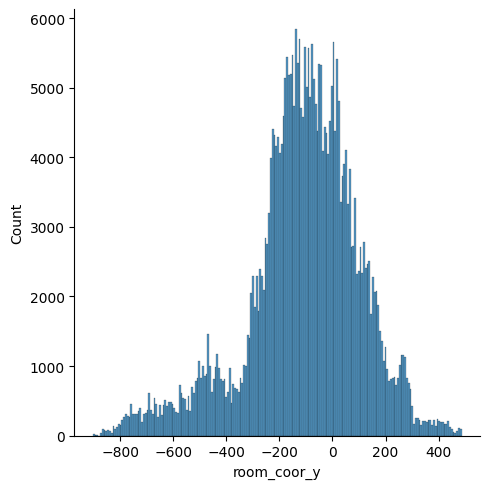

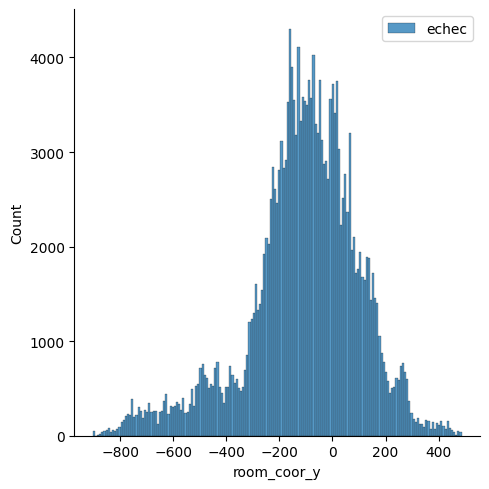

<Figure size 640x480 with 0 Axes>

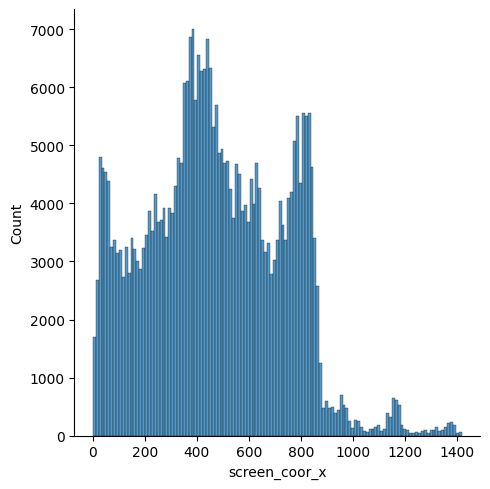

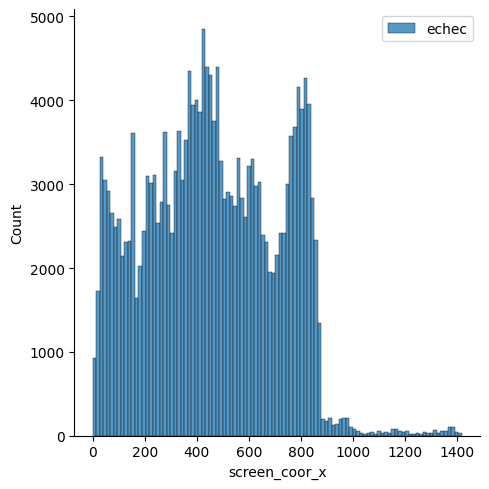

<Figure size 640x480 with 0 Axes>

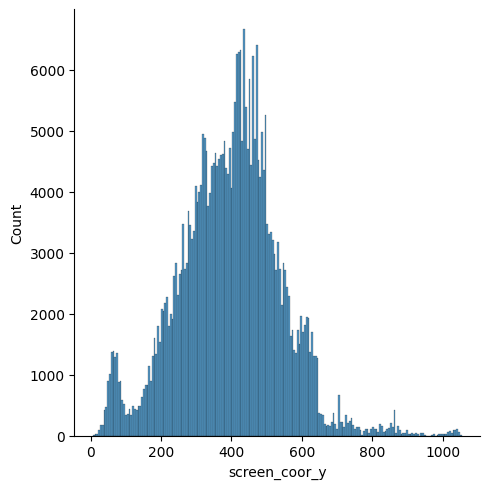

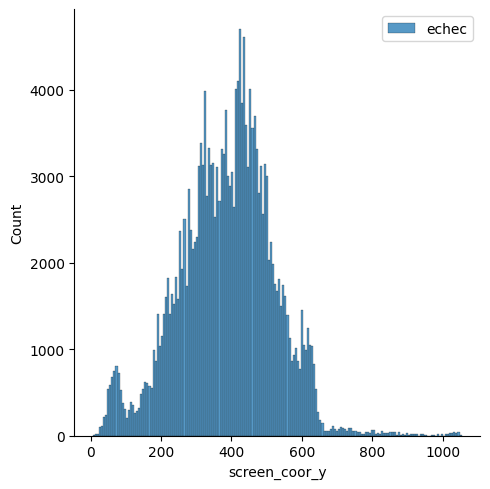

<Figure size 640x480 with 0 Axes>

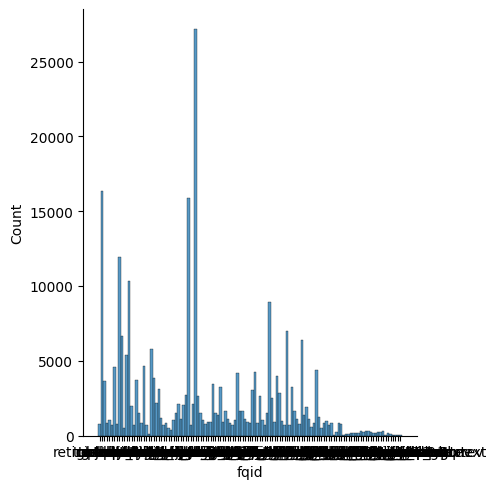

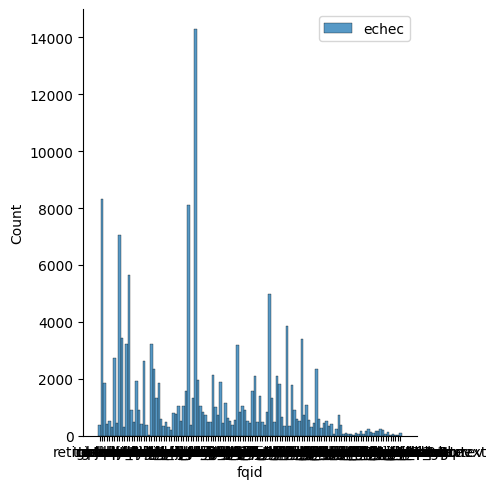

In [92]:
for col in little_na:
    plt.figure()
    sns.displot(reussite_df[col] , label = 'succès')
    sns.displot(echec_df[col] , label = 'echec')
    plt.legend()








<Axes: xlabel='fullscreen', ylabel='count'>

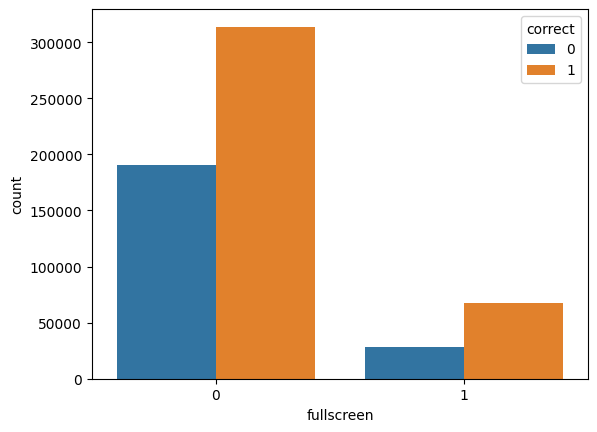

In [85]:
sns.countplot(x = 'fullscreen' ,  hue = 'correct' , data=df)

## Target / Medium_na

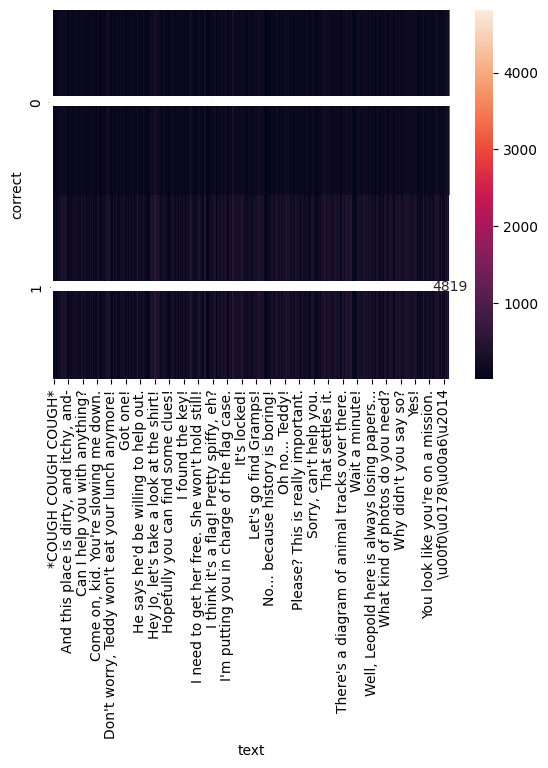

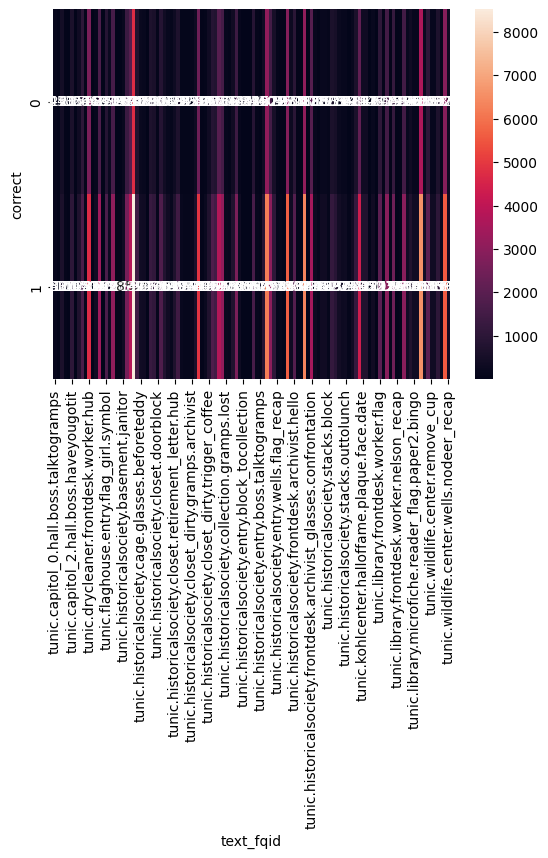

In [91]:
for col in medium_na:
    plt.figure()
    sns.heatmap(pd.crosstab(df['correct'] , df[col]) , annot=True , fmt='d')